In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import tqdm
from collections import defaultdict

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu



=== Dataset Summary ===
Total Normal images: 12428
Total Abnormal images: 768

File extensions:
Normal: {'.png': 12428}
Abnormal: {'.png': 768}


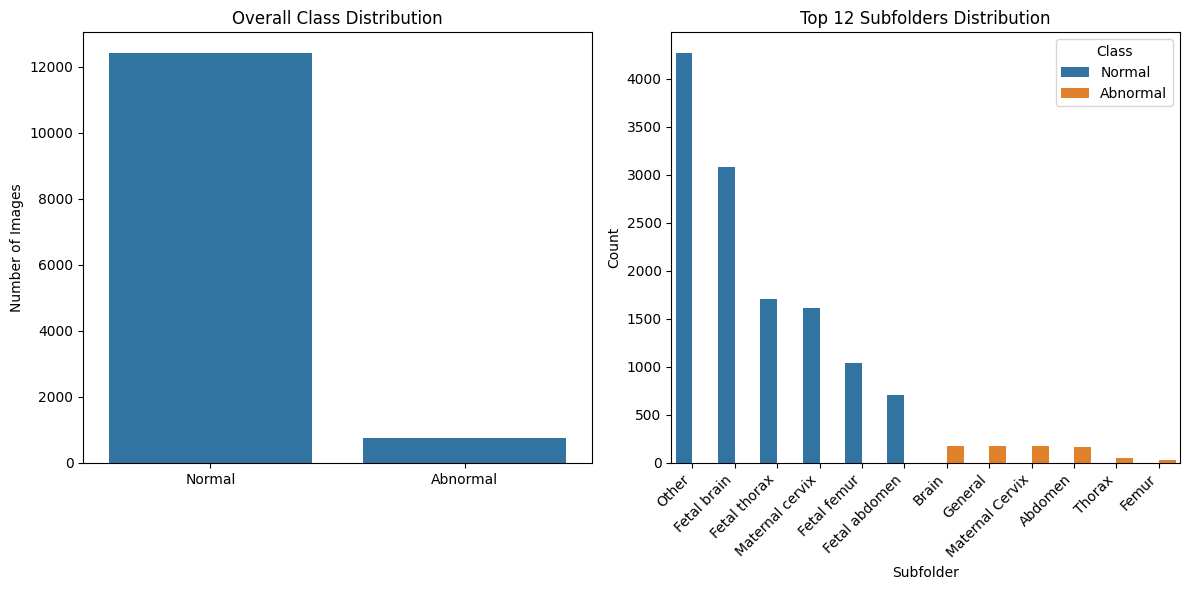


Detailed subfolder counts (Normal):
Maternal cervix: 1619 images
Other: 4272 images
Fetal brain: 3086 images
Fetal femur: 1036 images
Fetal thorax: 1711 images
Fetal abdomen: 704 images

Detailed subfolder counts (Abnormal):
Femur: 32 images
Brain: 176 images
Maternal Cervix: 172 images
Thorax: 51 images
General: 174 images
Abdomen: 163 images


In [4]:
# Define dataset paths
normal_path = "/content/drive/MyDrive/ML Project /Fetal-Health/Normal"
abnormal_path = "/content/drive/MyDrive/ML Project /Fetal-Health/Abnormality"

def analyze_folder_structure(directory):
    """Analyze and count images in directory and all subdirectories"""
    folder_stats = {
        'total_count': 0,
        'subfolder_counts': {},
        'extensions': defaultdict(int)
    }

    for root, dirs, files in os.walk(directory):
        # Get relative path from main directory
        rel_path = os.path.relpath(root, directory)

        # Count images in this folder
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        count = len(image_files)

        # Record counts
        if rel_path == '.':
            folder_name = 'Root'
        else:
            folder_name = rel_path

        if count > 0:
            folder_stats['subfolder_counts'][folder_name] = count
            folder_stats['total_count'] += count

            # Count file extensions
            for f in image_files:
                ext = os.path.splitext(f)[1].lower()
                folder_stats['extensions'][ext] += 1

    return folder_stats

# Analyze both folders
normal_stats = analyze_folder_structure(normal_path)
abnormal_stats = analyze_folder_structure(abnormal_path)

# Print summary statistics
print("\n=== Dataset Summary ===")
print(f"Total Normal images: {normal_stats['total_count']}")
print(f"Total Abnormal images: {abnormal_stats['total_count']}")
print("\nFile extensions:")
print("Normal:", dict(normal_stats['extensions']))
print("Abnormal:", dict(abnormal_stats['extensions']))

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=['Normal', 'Abnormal'], y=[normal_stats['total_count'], abnormal_stats['total_count']])
plt.title('Overall Class Distribution')
plt.ylabel('Number of Images')

# Plot subfolder distribution
plt.subplot(1, 2, 2)

# Combine subfolder counts for visualization
max_subfolders = 12  # Limit number of subfolders to show
all_subfolders = list(normal_stats['subfolder_counts'].keys()) + list(abnormal_stats['subfolder_counts'].keys())
top_subfolders = sorted(set(all_subfolders), key=lambda x: normal_stats['subfolder_counts'].get(x, 0) + abnormal_stats['subfolder_counts'].get(x, 0), reverse=True)[:max_subfolders]

# Prepare data for plotting
subfolder_data = []
for sf in top_subfolders:
    subfolder_data.append({
        'Subfolder': sf,
        'Normal': normal_stats['subfolder_counts'].get(sf, 0),
        'Abnormal': abnormal_stats['subfolder_counts'].get(sf, 0)
    })

df = pd.DataFrame(subfolder_data).melt(id_vars='Subfolder', var_name='Class', value_name='Count')

sns.barplot(data=df, x='Subfolder', y='Count', hue='Class')
plt.title(f'Top {max_subfolders} Subfolders Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print detailed subfolder counts if needed
print("\nDetailed subfolder counts (Normal):")
for folder, count in normal_stats['subfolder_counts'].items():
    print(f"{folder}: {count} images")

print("\nDetailed subfolder counts (Abnormal):")
for folder, count in abnormal_stats['subfolder_counts'].items():
    print(f"{folder}: {count} images")

In [5]:
def display_samples(class_path, title, num_samples=5):
    # Dictionary to store images by their subfolder
    subfolder_images = defaultdict(list)

    # Walk through directory and collect images by subfolder
    for root, dirs, files in os.walk(class_path):
        # Get relative path from the main class directory
        rel_path = os.path.relpath(root, class_path)

        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                full_path = os.path.join(root, file)
                subfolder_images[rel_path].append(full_path)

    # Display samples from each subfolder
    for subfolder, images in subfolder_images.items():
        if len(images) == 0:
            continue

        plt.figure(figsize=(15, 3))
        if subfolder == '.':
            plt.suptitle(f"{title} (Root Folder)", y=1.1)
        else:
            plt.suptitle(f"{title} - Subfolder: {subfolder}", y=1.1)

        # Display up to num_samples from this subfolder
        samples = np.random.choice(images, min(num_samples, len(images)), replace=False)

        for i, img_path in enumerate(samples):
            img = Image.open(img_path)
            plt.subplot(1, len(samples), i+1)
            plt.imshow(img)
            plt.axis('off')

        plt.show()

# Display sample images from both classes
display_samples(normal_path, "Normal Fetal Samples")
display_samples(abnormal_path, "Abnormal Fetal Samples")



Output hidden; open in https://colab.research.google.com to view.

In [6]:
# Create a custom dataset class
class FetalHealthDataset(Dataset):
    def __init__(self, normal_dir, abnormal_dir, transform=None):
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load normal images
        for root, dirs, files in os.walk(normal_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))
                    self.labels.append(0)  # 0 for normal

        # Load abnormal images
        for root, dirs, files in os.walk(abnormal_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, file))
                    self.labels.append(1)  # 1 for abnormal

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create dataset
full_dataset = FetalHealthDataset(normal_path, abnormal_path, transform=transform)

# Split into train and test sets
train_idx, test_idx = train_test_split(
    np.arange(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 10556
Test samples: 2640


In [7]:
import torch
import torch.nn as nn

# Define the Siamese Network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Feature extraction backbone
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        # Embedding network
        self.fc = nn.Sequential(
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        # Use the EXACT same names as in the saved model
        self.normal_abnormal_classifier = nn.Linear(128, 2)  # Must match saved weights
        self.body_part_classifier = nn.Linear(128, 12)       # Must match saved weights

    def forward_once(self, x):
        features = self.cnn(x)
        features = features.view(features.size(0), -1)
        embeddings = self.fc(features)
        return embeddings

    def forward(self, input1):
        embeddings = self.forward_once(input1)
        health_out = self.normal_abnormal_classifier(embeddings)
        part_out = self.body_part_classifier(embeddings)
        return health_out, part_out

# Load the pre-trained model with proper error handling
model_path = "/content/drive/MyDrive/ML Project /siamese_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)

try:
    # First try strict loading
    model.load_state_dict(torch.load(model_path, map_location=device))
    print("Model loaded successfully with exact match!")
except RuntimeError as e:
    print(f"Strict loading failed: {e}")
    print("Attempting to load with renamed parameters...")

    # Load state dict
    state_dict = torch.load(model_path, map_location=device)

    # Option 1: Rename parameters in current model to match saved model
    # (Already done in the class definition above)

    # Option 2: Create a mapping from old names to new names
    mapping = {
        'normal_abnormal_classifier.weight': 'health_head.weight',
        'normal_abnormal_classifier.bias': 'health_head.bias',
        'body_part_classifier.weight': 'part_head.weight',
        'body_part_classifier.bias': 'part_head.bias'
    }

    # Create new state dict with renamed keys
    new_state_dict = {}
    for key, value in state_dict.items():
        if key in mapping:
            new_state_dict[mapping[key]] = value
        else:
            new_state_dict[key] = value

    # Try loading again
    try:
        model.load_state_dict(new_state_dict)
        print("Model loaded successfully with parameter renaming!")
    except Exception as e:
        print(f"Failed to load model: {e}")
        print("Attempting non-strict loading...")
        model.load_state_dict(state_dict, strict=False)
        print("Model loaded with some parameters ignored")

model.eval()
print("Model ready for inference")

Model loaded successfully with exact match!
Model ready for inference


In [8]:
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader):
            # Convert RGB to grayscale if needed
            if inputs.shape[1] == 3:  # Check if input has 3 channels
                # Convert to grayscale by averaging channels
                inputs = inputs.mean(dim=1, keepdim=True)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - handle both single and dual output models
            outputs = model(inputs)

            # If model returns tuple (health_out, part_out), take health_out
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # Take the health classification output

            # Get predictions (assuming binary classification with sigmoid)
            preds = (outputs > 0.5).float()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred).flatten(), np.array(y_score).flatten()

# Evaluate on test set
y_true, y_pred, y_score = evaluate_model(model, test_loader)

100%|██████████| 83/83 [20:58<00:00, 15.16s/it]


100%|██████████| 83/83 [10:53<00:00,  7.87s/it]


Shapes - y_true: (2640,), y_pred: (2640,), y_score: (2640,)

Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      2486
    Abnormal       0.99      0.98      0.99       154

    accuracy                           1.00      2640
   macro avg       1.00      0.99      0.99      2640
weighted avg       1.00      1.00      1.00      2640



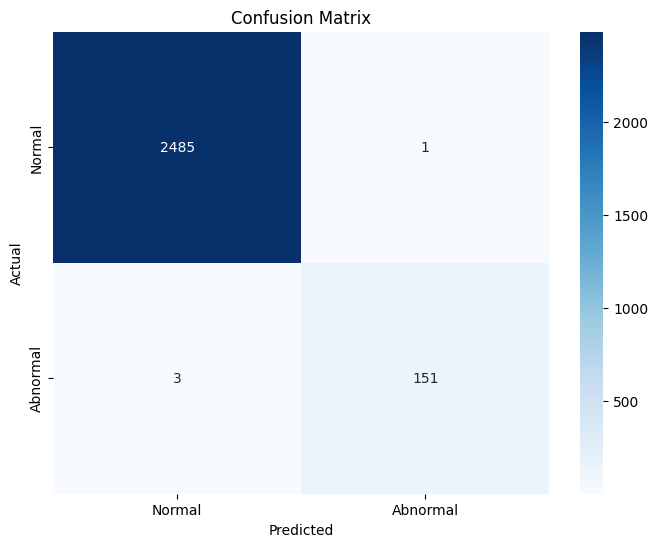

In [9]:
def evaluate_model(model, dataloader):
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader):
            # Ensure grayscale input (1 channel)
            if inputs.shape[1] == 3:
                inputs = inputs.mean(dim=1, keepdim=True)

            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Handle dual-output models - we only want the health classification
            if isinstance(outputs, tuple):
                health_output = outputs[0]  # Take first output (health classification)

                # For binary classification with sigmoid output
                if health_output.shape[1] == 1:  # Single output with sigmoid
                    preds = (health_output > 0.5).float()
                    scores = health_output
                else:  # Multi-class output (2 classes)
                    preds = torch.argmax(health_output, dim=1)
                    scores = torch.softmax(health_output, dim=1)[:, 1]  # Probability of abnormal class
            else:
                # Single output model
                if outputs.shape[1] == 1:  # Sigmoid output
                    preds = (outputs > 0.5).float()
                    scores = outputs
                else:  # Multi-class output
                    preds = torch.argmax(outputs, dim=1)
                    scores = torch.softmax(outputs, dim=1)[:, 1]

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_score.extend(scores.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_score)

# Re-evaluate
y_true, y_pred, y_score = evaluate_model(model, test_loader)

# Verify shapes
print(f"Shapes - y_true: {y_true.shape}, y_pred: {y_pred.shape}, y_score: {y_score.shape}")

# Classification report
if len(y_true) == len(y_pred):
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Abnormal']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Abnormal'],
                yticklabels=['Normal', 'Abnormal'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

else:
    print(f"Error: Mismatched lengths - y_true: {len(y_true)}, y_pred: {len(y_pred)}")

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def test_model_on_folder(model, root_folder, transform, device='cuda'):
    """
    Test model on images in subfolders, where folder name first word is the true class
    Args:
        model: Loaded Siamese model
        root_folder: Path to folder containing class subfolders
        transform: Image transforms used during training
        device: Device to run model on
    Returns:
        y_true: List of true labels (0 for Normal, 1 for Abnormal)
        y_pred: List of predicted labels
        results: List of tuples (image_path, true_class, pred_class, confidence)
    """
    y_true = []
    y_pred = []
    results = []
    class_map = {'Normal': 0, 'Abnormal': 1}

    # Get all image files in subfolders
    image_files = []
    for root, _, files in os.walk(root_folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append((root, file))

    if not image_files:
        print("No images found in the specified folder!")
        return [], [], []

    # Process each image
    for root, file in image_files:
        img_path = os.path.join(root, file)

        # Get true class from first word of folder name
        folder_name = os.path.basename(root)
        true_class = folder_name.split()[0]  # First word is class

        # Skip if folder name doesn't contain valid class
        if true_class not in class_map:
            print(f"Skipping {img_path} - invalid class in folder name")
            continue

        # Load and process image
        try:
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            img_tensor = transform(img).unsqueeze(0).to(device)

            # Predict
            with torch.no_grad():
                output = model(img_tensor)
                if isinstance(output, tuple):
                    output = output[0]  # Take health classification output

                # Handle different output types
                if output.shape[1] == 1:  # Sigmoid output
                    pred_prob = torch.sigmoid(output).item()
                    pred_class = 1 if pred_prob > 0.5 else 0
                    confidence = pred_prob if pred_class == 1 else 1 - pred_prob
                else:  # Softmax output
                    pred_prob = torch.softmax(output, dim=1)[0]
                    pred_class = torch.argmax(pred_prob).item()
                    confidence = pred_prob[pred_class].item()

            # Store results
            y_true.append(class_map[true_class])
            y_pred.append(pred_class)
            results.append((img_path, true_class,
                           'Normal' if pred_class == 0 else 'Abnormal',
                           confidence))

        except Exception as e:
            print(f"Error processing {img_path}: {str(e)}")
            continue

    return np.array(y_true), np.array(y_pred), results

# Define transform (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Path to your test folder
test_folder = "/content/drive/MyDrive/ML Project /Fetal-Health/testing purpose images"

# Run evaluation
y_true, y_pred, results = test_model_on_folder(
    model=model,
    root_folder=test_folder,
    transform=transform,
    device=device
)

# Print summary
if len(y_true) > 0:
    print(f"\nEvaluated {len(y_true)} images")
    print("Accuracy:", np.mean(y_true == y_pred))

    # Display some results
    print("\nSample predictions:")
    for i, (path, true_class, pred_class, conf) in enumerate(results[:5]):
        print(f"{i+1}. {path}")
        print(f"   True: {true_class}, Predicted: {pred_class} (Confidence: {conf:.2f})")

    # Visualize some examples
    plt.figure(figsize=(15, 10))
    for i, (path, true_class, pred_class, _) in enumerate(results[:6]):
        img = Image.open(path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"True: {true_class}\nPred: {pred_class}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No valid images found for evaluation!")

Output hidden; open in https://colab.research.google.com to view.

In [14]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [15]:
import gradio as gr
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

# Load the pre-trained model
model_path = "/content/drive/MyDrive/ML Project /siamese_model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def predict(image):
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    health_out, part_out = model(image)

    # Get predictions
    health_pred = torch.argmax(F.softmax(health_out, dim=1)).item()
    part_pred = torch.argmax(F.softmax(part_out, dim=1)).item()

    health_labels = ["Normal", "Abnormal"]

    return f"Health Status: {health_labels[health_pred]}"

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Textbox(label="Health Status")],
    title="Siamese Network Health & Body Part Classifier",
    description="Upload an X-ray image to classify if it's normal or abnormal and identify the body part."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c264ec1e6bede32fe9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
